`transformer_experimentation.ipynb` did not succeed in learning even a linear function.
This is why here a simple general transformer example is adapted to work on time-series data as in Wu et. al.

# Prelude

In [1]:
import sys
import pathlib as pl
sys.path.insert(0,str(pl.Path("../").absolute()))

In [2]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn # neuronal layers, function objects
import torch.nn.functional as F # contains activation functions
from torch.autograd import Variable # wrapper for tensor
import torch.optim as opt
import numpy as np
import sklearn.preprocessing as skp
from utils.data_loader import load_data
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass, asdict
from typing import *
import datetime

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cpu


In [4]:
#data_temp, data_wind = load_data()
#display(data_temp.head(3))
#display(data_wind.head(3))

,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:42,526487,467544,442
1,2022-01-22 13:53:44,526542,467315,461
2,2022-01-22 13:53:45,526532,466868,466


,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:37,505940,507749,621
1,2022-01-22 13:53:38,505846,507807,632
2,2022-01-22 13:53:40,505990,507764,629


## helpers


In [5]:

def wrapBatch(data):
    data = data
    shape = list(data.shape)
    shape.insert(1,1)
    return np.reshape(data, shape)

def get_mask(dim1: int, dim2: int) -> torch.Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Modified from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    Args:

        dim1: int, for both src and tgt masking, this must be target sequence
              length

        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 


    Return:

        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)


## Define Transformer

define encoder

In [6]:
# adapted from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term) # TODO: why does this crash when d_model = 3?
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Encoder(nn.Module):
    def __init__(self, d_input, d_model, nhead=1):
        super(Encoder, self).__init__()

        # define layers (layers are functions)
        self.input_layer = nn.Linear(d_input, d_model) # input layer, 10 features in, 10 features out (== keras dense)
        self.pos_encoding_layer = PositionalEncoding(d_model,dropout=0.2)
        self.encoder_layers = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.2), num_layers=4) # stacks multiple encoder layers, contains self attention and feed forward with normalization in between, TODO: how many heads?

    # forward pass data x through network
    def forward(self, x: torch.Tensor):
        x = self.input_layer(x)
        x = self.pos_encoding_layer(x)
        x = self.encoder_layers(x)
        return x[0] # we ignore batching here, expected shape of x: [batch][pos in seq][dim]

define decoder

In [7]:

class Decoder(nn.Module):
    def __init__(self, d_input, d_model, nhead=1):
        super(Decoder, self).__init__()

        # define layers (layers are functions)
        self.input_layer = nn.Linear(d_input, d_model) # input layer, 10 features in, 10 features out (== keras dense)
        self.decoder_layers = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=0.2), num_layers=4)
        self.linear_mapping = nn.Linear(
            in_features=d_model, 
            out_features=d_input
            )


    # forward pass data x through network
    def forward(self, x: torch.Tensor, memory: torch.Tensor, mask: torch.Tensor): #NOTE: TODO: implement Masking
        x = self.input_layer(x)
        x = self.decoder_layers(x,memory=memory,tgt_mask=mask)
        x = self.linear_mapping(x)
        return x
    

In [8]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_input, d_model,nhead=8):
        super(TimeSeriesTransformer, self).__init__()

        # define layers
        self.encoder = Encoder(d_input, d_model,nhead=nhead)
        self.decoder = Decoder(d_input, d_model,nhead=nhead)

        self.memory = None

    def encode(self, src: torch.Tensor):
        encoding = self.encoder(src)
        self.memory = encoding

    def forward(self, target: torch.Tensor, mask: torch.Tensor):
        if self.memory == None:
            raise ValueError("you need to call encode() first")
        out = self.decoder(x=target,memory=self.memory, mask=mask)
        return out

generate fake data (linear)

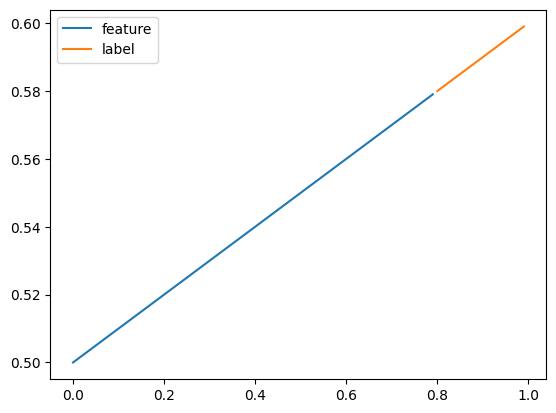

In [9]:
a = 0.1
b = 0.5
data_x = np.arange(0,1,0.01)
data_y = [a*y+b for y in data_x]

# split "window" into feature and label as in Wu et al
rel = 0.8
feature = data_y[:int(rel*len(data_y))]
label = data_y[int(rel*len(data_y)):]
plt.plot(data_x[:int(rel*len(data_y))],feature, label="feature")
plt.plot(data_x[int(rel*len(data_y)):],label, label="label")
plt.legend()

In [10]:
feature = torch.Tensor(feature).to(device)
label = torch.Tensor(label).to(device)

Network Training

In [29]:
#%%
d_input = 1
d_model = 4
net = TimeSeriesTransformer(1, d_model,nhead=4)
net.to(device)
net.train(True)
learning_rate = 0.0001
optimizer = opt.Adam(net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
num_epochs = 100

#%%
losses = []
# go through every datapoint (1)
for i in range(num_epochs):
    # apply gradient to each epoch
    net.zero_grad()
    optimizer.zero_grad()
    
    net.encode(torch.unsqueeze(feature,0).T)

    predicted_labels = []
    # we start with last feature label as input(do not use in loss)
    # last label does not get used for input only for error lost
    target_labels = [feature[-1]] + list(label) 
    # train every step in window individually
    for sp in range(len(target_labels)-1):
        decoder_input = target_labels[:sp+1]
        decoder_input = torch.Tensor(decoder_input).to(device)
        decoder_input = torch.unsqueeze(decoder_input,0)
        #decoder_input = torch.unsqueeze(decoder_input,0)
        decoder_input = decoder_input.T
        out = net.forward(decoder_input,None)
        newly_predicted = out[-1] # always only one new because of shifted label prediction
        predicted_labels.append(newly_predicted) 
        
    # first label was only to feed input
    y_label = torch.tensor(target_labels[1:]).to(device)
    y_predicted = torch.squeeze(torch.stack(predicted_labels))
    #print(y_label.shape, y_predicted)
    loss = criterion(y_label, y_predicted)
    loss.backward()
    optimizer.step()
    if i % 10 == 0: print(f"{i}: loss={loss}")

#%%
# example result of trained net and conversion to numpy
#x_numpy = np.array([1,0,0,0,1,0,0,0,1,1])
#x = torch.Tensor(x_numpy).to(net.device)
#y = net(x)
#y_numpy = y.detach().cpu().numpy()
#print("in  ", x_numpy.astype(np.int8))
#print("out ", np.abs(np.rint(y_numpy)).astype(np.int8)) # as nearest (positive) int
# %% 

0: loss=0.3432275652885437
10: loss=0.1874697506427765
20: loss=0.1810413897037506
30: loss=0.17393295466899872
40: loss=0.1652798354625702
50: loss=0.1608036458492279
60: loss=0.15694263577461243
70: loss=0.15129125118255615
80: loss=0.14304712414741516
90: loss=0.13817426562309265


In [48]:
net.encode(torch.unsqueeze(feature,0).T)
res = torch.Tensor(torch.unsqueeze(label,0).T).to(device)
out = net(res,None)
out

In [ ]:
np.var()